In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("Set2")

params = {'legend.fontsize': 'large',
          'font.family': 'serif',
          'figure.figsize': (13,9),
          'axes.labelsize': 14,
          'axes.titlesize': 18,
          'xtick.labelsize': 14*0.75,
          'ytick.labelsize': 14*0.75}
plt.rcParams.update(params)

import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

randomState = 42

In [2]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten, Masking, GlobalAveragePooling1D
from tensorflow.keras.metrics import AUC, Accuracy
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import concatenate
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

## Read in RQ data

In [3]:
dfFFR = pd.read_pickle('../intermediatePickles/FFRRQs.pkl')
dfgX = pd.read_pickle('../intermediatePickles/gXRQs.pkl')

print('%i gX waveforms loaded' % len(dfgX))
print('%i FFR waveforms loaded' % len(dfFFR))

gxRQs = dfgX[['TBA', 'clusterSize', 'topPeakFraction', 'bottomPeakFraction']].to_numpy(dtype = float)
FFRRQs = dfFFR[['TBA', 'clusterSize', 'topPeakFraction', 'bottomPeakFraction']].to_numpy(dtype = float)

69880 gX waveforms loaded
80928 FFR waveforms loaded


# Read in waveform data

In [4]:
%%time

waveformFilePath = '/global/cfs/cdirs/lz/users/chami/GammaX/RFRvsFFRWaveforms/waveformData/'

waveformFileListFFR = ['FFR_1_waveforms.npy',
                       'FFR_2_waveforms.npy',
                       'FFR_3_waveforms.npy',
                       'FFR_4_waveforms.npy',
                       'FFR_5_waveforms.npy',
                       'FFR_6_waveforms.npy',
                       'FFR_7_waveforms.npy',
                       'FFR_8_waveforms.npy']

waveformPathsFFR = [waveformFilePath + file for file in waveformFileListFFR]

# Read in FFR waveforms
waveformsFFR = np.load(waveformPathsFFR[0], allow_pickle = True)

for file in waveformPathsFFR[1:]:
    waveformsFFR = np.concatenate((waveformsFFR, np.load(file, allow_pickle = True)))
    
with open("../intermediatePickles/gXWaveforms.pkl", 'rb') as f:
    gXWaveforms = pickle.load(f)
    
print('%i gX waveforms loaded' % len(gXWaveforms))
print('%i  waveforms loaded' % len(waveformsFFR))

if len(gXWaveforms) != len(dfgX):
    raise Exception("Gamma X RQs and waveforms don't match!")
if len(waveformsFFR) != len(dfFFR):
    raise Exception("FFR RQs and waveforms don't match!")

69880 gX waveforms loaded
80928  waveforms loaded
CPU times: user 330 ms, sys: 76 ms, total: 406 ms
Wall time: 819 ms


## Preprocessing

In [5]:
def truncateFromAFT5(waveformArray):
    
    truncatedWaveforms = []
    
    for i, waveform in enumerate(waveformArray):
        waveformCumSum = waveform.cumsum()
        # Get the index of wave amplitude 50ns before AFT5
        startIndex = max(0, np.argmax(waveformCumSum > 0.05) - 10)
        truncatedWaveforms.append(waveform[startIndex:])
    
    return np.array(truncatedWaveforms)

In [6]:
%%time

# Normalize
gX = np.array([waveform / waveform.sum() for waveform in gXWaveforms])
FFR = np.array([waveform / waveform.sum() for waveform in waveformsFFR])

# Create common data set
nSamplesEach = min(len(gX), len(FFR))

# Balance the waveform data
gX = gX[:nSamplesEach]
FFR = FFR[:nSamplesEach]
# Balance the RQ data
gxRQs = gxRQs[:nSamplesEach]
FFRRQs = FFRRQs[:nSamplesEach]

# Concatenate
waveformData = np.concatenate((gX, FFR))
RQData = np.concatenate((gxRQs, FFRRQs))

# Create truth values. 1 if gX, 0 if FFR
gXTruth = np.concatenate((np.ones(nSamplesEach), np.zeros(nSamplesEach)))

truncatedData = truncateFromAFT5(waveformData)
paddedData = sequence.pad_sequences(truncatedData, maxlen = 50, dtype = float, padding = 'post')

reshapedPaddedData = np.reshape(paddedData, tuple([*np.shape(paddedData)] + [1]))
reshapedRQData = np.reshape(RQData, tuple([*np.shape(RQData)]))

# Split training and testing sets
waveformTrain, waveformTest, rqTrain, rqTest, yTrain, yTest = train_test_split(reshapedPaddedData, 
                                                                               reshapedRQData, 
                                                                               gXTruth, 
                                                                               test_size = 0.3,
                                                                               random_state = 0,
                                                                               shuffle = True)

CPU times: user 1.82 s, sys: 51.2 ms, total: 1.87 s
Wall time: 1.86 s


## Build CNN

In [7]:
def CNN():
    
    ### First input - waveforms ###
    # Input and mask
    waveformInput = Input(shape = waveformInputShape[1:], dtype = float)
    maskingLayer = Masking(mask_value = 0.0)(waveformInput)
    
    # First convolutional layer
    conv1 = Conv1D(filters = 250, kernel_size = 7, activation = 'relu')(maskingLayer)
    maxPool1 = MaxPooling1D(pool_size = 2)(conv1)
    dropout1 = Dropout(0.3)(maxPool1)
    
    # Second convolutional layer
#     conv2 = Conv1D(filters = 150, kernel_size = 7, activation = 'relu')(dropout1)
#     maxPool2 = MaxPooling1D(pool_size = 2)(conv2)
#     dropout2 = Dropout(0.3)(maxPool2)
    
    flatten = Flatten()(dropout1)
    
    ### Second input  - RQ information ###
    rqInput = Input(shape = (4,), dtype = float)
    
    # Concatenate inputs to feed into fully connected layers
    mergedVector = concatenate([flatten, rqInput])

    # Fully connected layers
    dense1 = Dense(20, activation = 'relu')(mergedVector)
    dense2 = Dense(15, activation = 'relu')(dense1)
    dense3 = Dense(10, activation = 'relu')(dense2)
    dense4 = Dense(5, activation = 'relu')(dense3)
    dense5 = Dense(1, activation = 'sigmoid')(dense4)
    
    # Create model from layers
    model = Model(inputs = [waveformInput, rqInput], outputs = dense5)
    
    # Compile
    model.compile(loss = 'binary_crossentropy',
                  optimizer = 'Nadam',
                  metrics = ['accuracy', AUC(name = 'auc')])
    
    # Summarize the model
    print(model.summary())
    
    return model

In [8]:
waveformInputShape = (len(waveformTrain), len(waveformTrain[0]), 1)
# waveformCNN = CNN()
waveformCNN = CNN()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
masking (Masking)               (None, 50, 1)        0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 44, 250)      2000        masking[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 22, 250)      0           conv1d[0][0]                     
______________________________________________________________________________________________

In [9]:
%%time 

# logDir = 'TensorboardLogs/' #+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboardCallback = tf.keras.callbacks.TensorBoard(log_dir = logDir, histogram_freq = 1)

history = waveformCNN.fit(x = [waveformTrain, rqTrain],
                          y = yTrain,
                          validation_data = ([waveformTest, rqTest], yTest),
                          batch_size = 50,
                          epochs = 20)
#                           callbacks = [tensorboardCallback])

print("Trained!")
waveformCNN.save('waveformModel_withRQs.h5')
print("Saved!")

Train on 97832 samples, validate on 41928 samples
Epoch 1/20
97832/97832 [==============================] - 66s 679us/sample - loss: 0.3343 - accuracy: 0.8435 - auc: 0.9270 - val_loss: 0.2335 - val_accuracy: 0.9075 - val_auc: 0.9674
Epoch 2/20
97832/97832 [==============================] - 52s 533us/sample - loss: 0.2364 - accuracy: 0.8978 - auc: 0.9629 - val_loss: 0.2194 - val_accuracy: 0.9102 - val_auc: 0.9704
Epoch 3/20
97832/97832 [==============================] - 51s 524us/sample - loss: 0.2157 - accuracy: 0.9078 - auc: 0.9695 - val_loss: 0.1971 - val_accuracy: 0.9170 - val_auc: 0.9767
Epoch 4/20
97832/97832 [==============================] - 58s 594us/sample - loss: 0.2042 - accuracy: 0.9113 - auc: 0.9732 - val_loss: 0.1953 - val_accuracy: 0.9208 - val_auc: 0.9786
Epoch 5/20
97832/97832 [==============================] - 53s 540us/sample - loss: 0.1973 - accuracy: 0.9141 - auc: 0.9751 - val_loss: 0.2005 - val_accuracy: 0.9186 - val_auc: 0.9788
Epoch 6/20
97832/97832 [===========

In [10]:
from tensorflow.keras.models import load_model
waveformCNN = load_model('waveformModel_withRQs.h5', compile = False)

In [39]:
waveformOnlyCNN = load_model('../models/waveformModel.h5', compile = False)

## Evaluation

In [40]:
%%time

yPredTestCNN = waveformCNN.predict([waveformTest, rqTest])
yPredTrainCNN = waveformCNN.predict([waveformTrain, rqTrain])

yPredTestRFR_CNN = yPredTestCNN[yTest == 1]
yPredTrainRFR_CNN = yPredTrainCNN[yTrain == 1]

yPredTestFFR_CNN = yPredTestCNN[yTest == 0]
yPredTrainFFR_CNN = yPredTrainCNN[yTrain == 0]

CPU times: user 1min 26s, sys: 7.66 s, total: 1min 33s
Wall time: 21.5 s


In [41]:
nBins = 50

plt.figure(figsize = (15, 5))
plt.hist(yPredTrainRFR_CNN,
         bins = nBins,
         density = True,
         alpha = 0.4,
         color = palette[0],
         label = "Train gX")
counts, binEdges = np.histogram(yPredTestRFR_CNN, bins = nBins, density = True)
binCenters = (binEdges[:-1] + binEdges[1:]) / 2
plt.plot(binCenters,
         counts,
         marker = 'o',
         ls = "None",
         color = palette[0],
         label = "Test gX")

plt.hist(yPredTrainFFR_CNN,
         bins = nBins,
         density = True,
         alpha = 0.4,
         color = palette[1],
         label = "Train FFR")
counts, binEdges = np.histogram(yPredTestFFR_CNN, bins = nBins, density = True)
binCenters = (binEdges[:-1] + binEdges[1:]) / 2
plt.plot(binCenters,
         counts,
         marker = 'o',
         ls = "None",
         color = palette[1],
         label = "Test FFR")
plt.legend(loc = 'center')
plt.title('CNN')
plt.xlabel('Model Output')
plt.show()

In [12]:
 plt.figure(1,figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.figure(2,figsize=(10,5))
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(3,figsize=(10,5))
# summarize history for loss
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [13]:
# Assuming the FRF RFR split is at CNN output = 0.5
confusionMatrixNN_new = confusion_matrix(np.array(yTest), np.round(yPredTestCNN), normalize = 'true')
pd.DataFrame(confusionMatrixNN_new, 
             index = ['Actual FFR', 'Actual gX'], 
             columns = ['Predicted FFR', 'Predicted gX'])

Predicted FFR  Predicted gX
Actual FFR       0.933153      0.066847
Actual gX        0.072941      0.927059

In [32]:
# Assuming the FRF RFR split is at CNN output = 0.5
confusionMatrixNN = confusion_matrix(np.array(yTest), np.round(loadedModel.predict(waveformTest)))
pd.DataFrame(confusionMatrixNN, 
             index = ['Actual FFR', 'Actual gX'], 
             columns = ['Predicted FFR', 'Predicted gX'])

Predicted FFR  Predicted gX
Actual FFR          16969          4079
Actual gX            1921         18959

In [14]:
layerOutputs = [layer.output for layer in waveformCNN.layers]
activationModel = Model(inputs = waveformCNN.input, outputs = layerOutputs)

In [15]:
%time activations = activationModel.predict([waveformTest, rqTest][:100])

CPU times: user 39.9 s, sys: 6.94 s, total: 46.8 s
Wall time: 7.61 s


In [16]:
for i in range(len(activations)):
    print(activations[i].shape)


(41928, 50, 1)
(41928, 50, 1)
(41928, 44, 250)
(41928, 22, 250)
(41928, 22, 250)
(41928, 5500)
(41928, 4)
(41928, 5504)
(41928, 20)
(41928, 15)
(41928, 10)
(41928, 5)
(41928, 1)


In [21]:
conv1 = activations[2][0]
print(conv1.shape)

(44, 250)


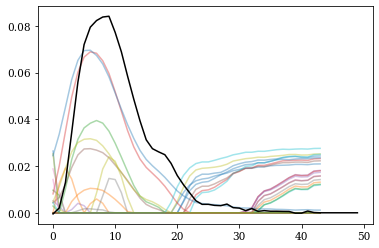

In [38]:
j = 11
conv1 = activations[2][j]
for i in range(250):
    if not all(wave == 0 for wave in conv1[:,i]):
        plt.plot(conv1[:,i], alpha = 0.4)
plt.plot(waveformTest[j], 'k')
plt.show()

In [20]:
flattenLayer.shape

(2000, 4000)

In [21]:
%time tsneEmbedded = TSNE(n_components = 2).fit_transform(flattenLayer)

CPU times: user 1min 4s, sys: 359 ms, total: 1min 4s
Wall time: 1min 4s


In [41]:
df = pd.DataFrame(data = tsneEmbedded, columns = ['xTSNE', 'yTSNE'])

db = DBSCAN(eps = 2.88, min_samples = 5).fit(tsneEmbedded)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

df['tSNE'] = list(labels)
df['tSNE'] = df['tSNE'].astype('int')
df['gX'] = yTest[:2000]

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 15


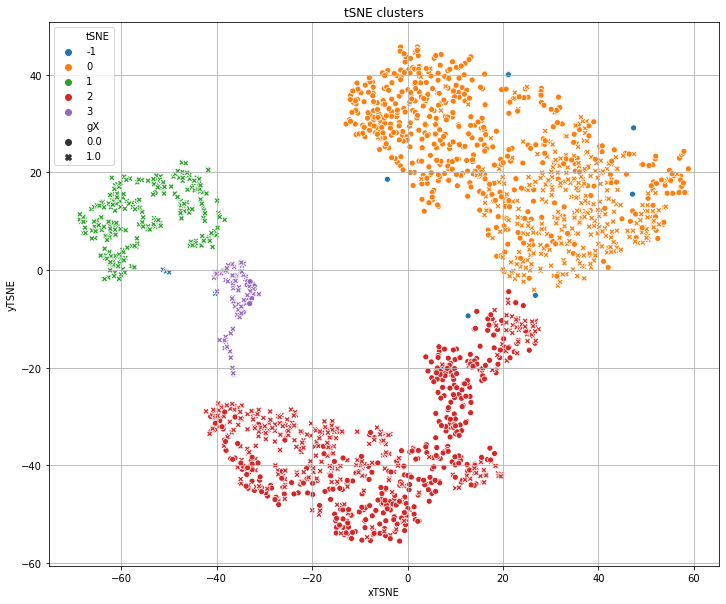

In [56]:
plt.figure(figsize = (12, 10))
sns.scatterplot(x = 'xTSNE',
                y = 'yTSNE',
                data = df,
                hue = 'tSNE',
                style = 'gX',
                markers = {0.0: 'o', 1.0: 'X'},
                palette = sns.color_palette(None, n_clusters_ + 1),
                legend = 'full'
               )
plt.grid()
plt.title("tSNE clusters")
plt.show()

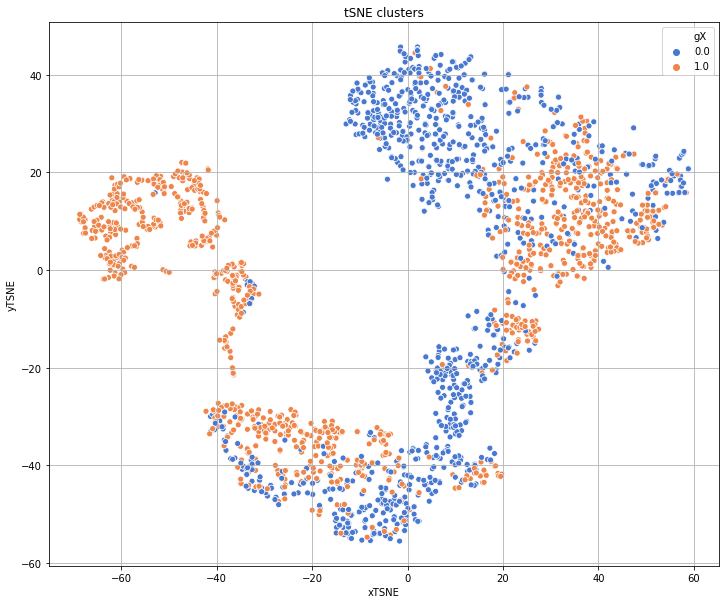

In [43]:
plt.figure(figsize = (12, 10))
sns.scatterplot(x = 'xTSNE',
                y = 'yTSNE',
                data = df,
                hue = 'gX',
                palette = sns.color_palette('muted', 2),
                legend = 'full'
               )
plt.grid()
plt.title("tSNE clusters")
plt.show()

In [57]:
tSNE_0_indices = df.index[df.tSNE == 0].to_list()
tSNE_1_indices = df.index[df.tSNE == 1].to_list()
tSNE_2_indices = df.index[df.tSNE == 2].to_list()
tSNE_3_indices = df.index[df.tSNE == 3].to_list()
tSNE_noise_indices = df.index[df.tSNE == -1].to_list()

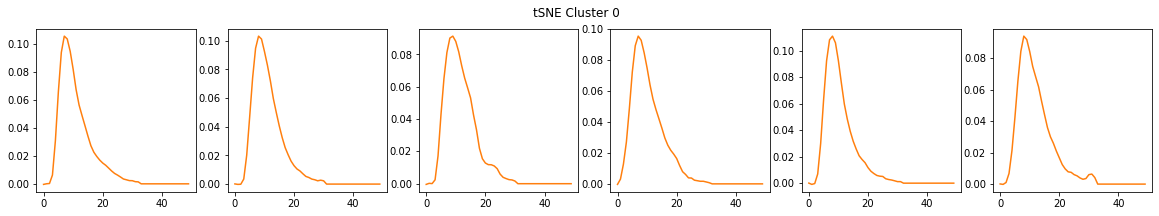

In [61]:
fig, axes = plt.subplots(1, 6, figsize = (20, 3))

for i, ax in enumerate(axes.flatten()):
    ax.plot(xTest[tSNE_0_indices[i]], color = sns.color_palette(None, n_clusters_ + 1)[1])
plt.suptitle('tSNE Cluster 0')
plt.show()

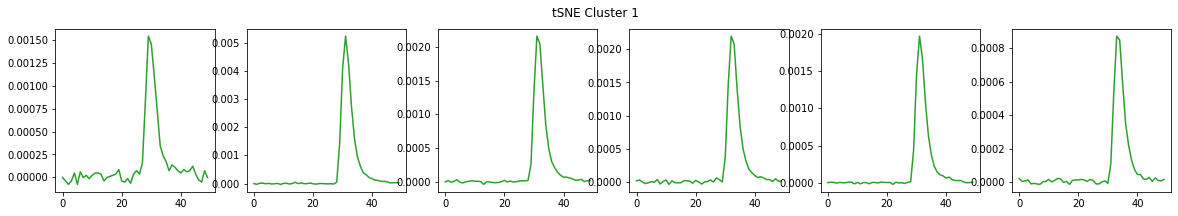

In [62]:
fig, axes = plt.subplots(1, 6, figsize = (20, 3))

for i, ax in enumerate(axes.flatten()):
    ax.plot(xTest[tSNE_1_indices[i]], color = sns.color_palette(None, n_clusters_ + 1)[2])
plt.suptitle('tSNE Cluster 1')
plt.show()

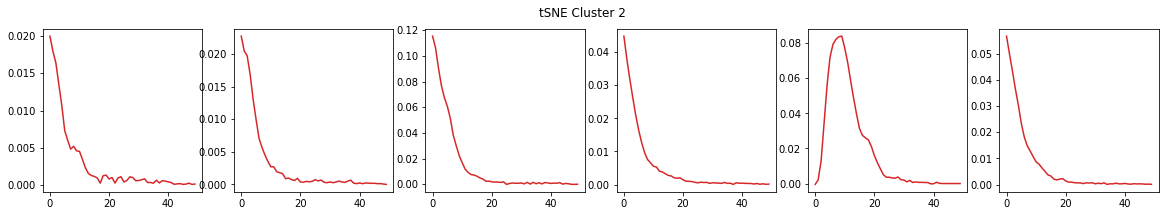

In [63]:
fig, axes = plt.subplots(1, 6, figsize = (20, 3))

for i, ax in enumerate(axes.flatten()):
    ax.plot(xTest[tSNE_2_indices[i]], color = sns.color_palette(None, n_clusters_ + 1)[3])
plt.suptitle('tSNE Cluster 2')
plt.show()

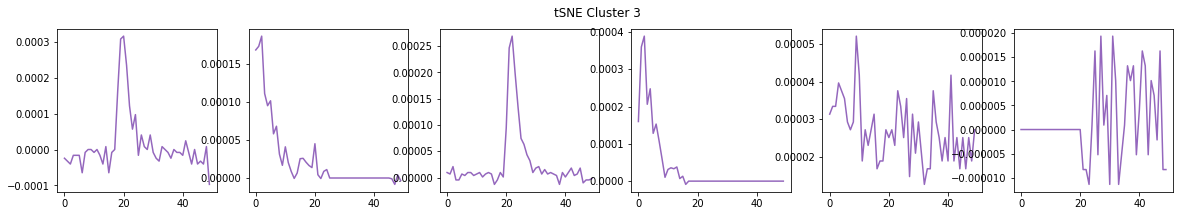

In [64]:
fig, axes = plt.subplots(1, 6, figsize = (20, 3))

for i, ax in enumerate(axes.flatten()):
    ax.plot(xTest[tSNE_3_indices[i]], color = sns.color_palette(None, n_clusters_ + 1)[4])
plt.suptitle('tSNE Cluster 3')
plt.show()

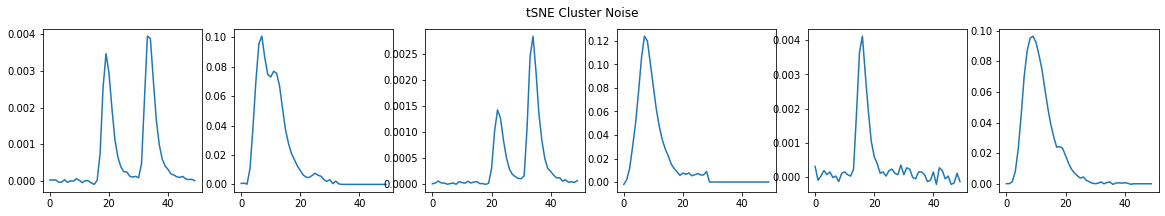

In [65]:
fig, axes = plt.subplots(1, 6, figsize = (20, 3))

for i, ax in enumerate(axes.flatten()):
    ax.plot(xTest[tSNE_noise_indices[i]], color = sns.color_palette(None, n_clusters_ + 1)[0])
plt.suptitle('tSNE Cluster Noise')
plt.show()

In [99]:
f'AUC score for CNN is {round(roc_auc_score(yTest, loadedModel.predict(xTest)), 4)}'

'AUC score for CNN is 0.9373'

## Model Comparisons

In [42]:
yPredTestCNNWaveformOnly = waveformOnlyCNN.predict(waveformTest)
yPredTrainCNNWaveformOnly = waveformOnlyCNN.predict(waveformTrain)

In [43]:
FalsePosTestCNN1, TruePosTestCNN1, _ = roc_curve(yTest, yPredTestCNNWaveformOnly, pos_label = 1)
FalsePosTestCNN2, TruePosTestCNN2, _ = roc_curve(yTest, yPredTestCNN, pos_label = 1)

In [44]:
with open('../intermediatePickles/tempXGBoostCompare.pkl', 'rb') as f:
    FalsePosTestXGB, TruePosTestXGB = pickle.load(f)

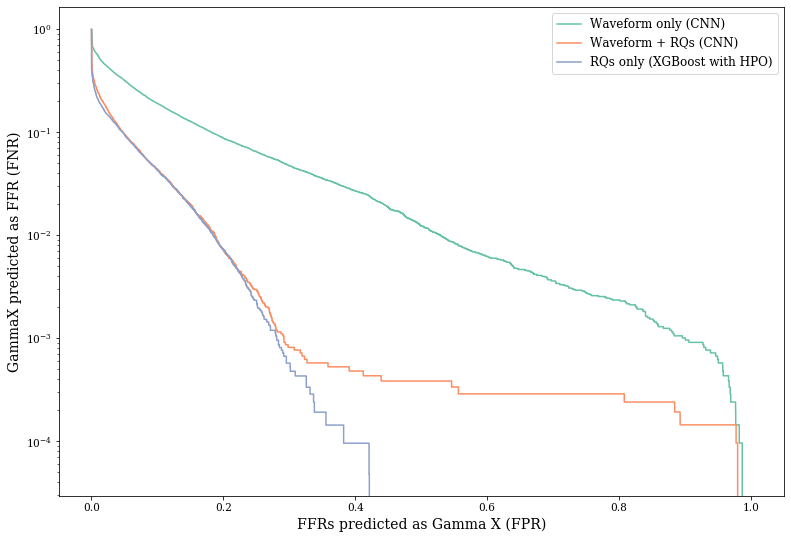

In [58]:
plt.plot(FalsePosTestCNN1, 1-TruePosTestCNN1, color = palette[0], label = "Waveform only (CNN)")
plt.plot(FalsePosTestCNN2, 1-TruePosTestCNN2, color = palette[1], label = "Waveform + RQs (CNN)")
plt.plot(FalsePosTestXGB, 1-TruePosTestXGB, color = palette[2], label = "RQs only (XGBoost with HPO)")

plt.xlabel('FFRs predicted as Gamma X (FPR)')
plt.ylabel('GammaX predicted as FFR (FNR)')
plt.yscale('log')
# plt.xscale('log')
plt.legend()#loc = 'lower left')
plt.show()